In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import scipy
import math
from collections import OrderedDict

from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score ,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.impute import KNNImputer , SimpleImputer
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OrdinalEncoder, OneHotEncoder

from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer , FunctionTransformer
from sklearn.compose import ColumnTransformer

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import ColumnSelector

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier, plot_tree
import xgboost as xgb
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif ,chi2 

from sklearn.tree import export_graphviz
from sklearn import tree

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import auc, roc_curve
import time

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [6]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
display(train_data.head(5))
display(train_data.shape)
display(train_data.info())
display(train_data.nunique())
print('Number of duplicate rows (including first) in the table is:', train_data[train_data.duplicated(keep=False)].shape[0])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Number of duplicate rows (including first) in the table is: 0


In [9]:
#Starting manupulating dataframe
dfv01=train_data.copy()

In [10]:
"""Converting features into appropriate data types """
dfv01['PassengerId'] = dfv01['PassengerId'].astype('object')
dfv01['Sex'] = dfv01['Sex'].astype('category')
dfv01['Embarked'] = dfv01['Embarked'].astype('category')
display(dfv01.dtypes)

PassengerId      object
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [11]:
# Descriptive stats for categorical features only.
category_columns = dfv01.select_dtypes(['category']).columns
dfv01[category_columns].describe().T

,count,unique,top,freq
Sex,891,2,male,577
Embarked,889,3,S,644


In [12]:
#Fixing "nan" in Embarked with most common location
dfv01['Embarked']=dfv01['Embarked'].fillna('S')

In [13]:
def show_values(plot):
    for ax in plot.axes.ravel():
        # add annotations
        for c in ax.containers:
            # custom label calculates percent and add an empty string so 0 value bars don't have a number
            labels = [f'{w:0.0f}' if (w := v.get_height()) > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=0, padding=2)
        ax.margins(y=0.2)

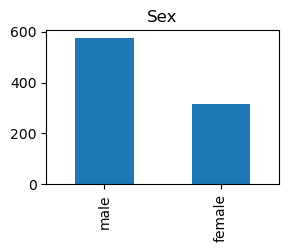

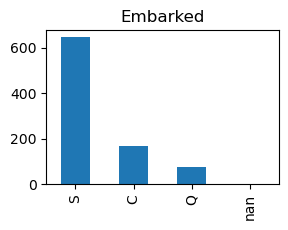

In [14]:
for column in category_columns:
    f = train_data[column].value_counts(dropna=False).plot(kind='bar', figsize=(3,2), title=column)
    plt.show()

In [15]:
dfv01.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [16]:
print(f"Pclass\n{dfv01['Pclass'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Embarked\n{dfv01['Embarked'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")

Pclass
3    55.1%
1    24.2%
2    20.7%
Name: Pclass, dtype: object
Embarked
S    72.5%
C    18.9%
Q     8.6%
Name: Embarked, dtype: object


In [17]:
print("Kurtosis value of the Fare attribute",kurtosis(dfv01.Fare, axis=0, bias=True))
print("Skewness value of the Fare attribute",skew(dfv01.Fare, axis=0, bias=True))

Kurtosis value of the Fare attribute 33.20428925264474
Skewness value of the Fare attribute 4.7792532923723545


/tmp/ipykernel_21/885393980.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.displot(data=dfv01,  x='Fare', hue='Survived',multiple="stack", aspect=3,hue_order= [1, 0],


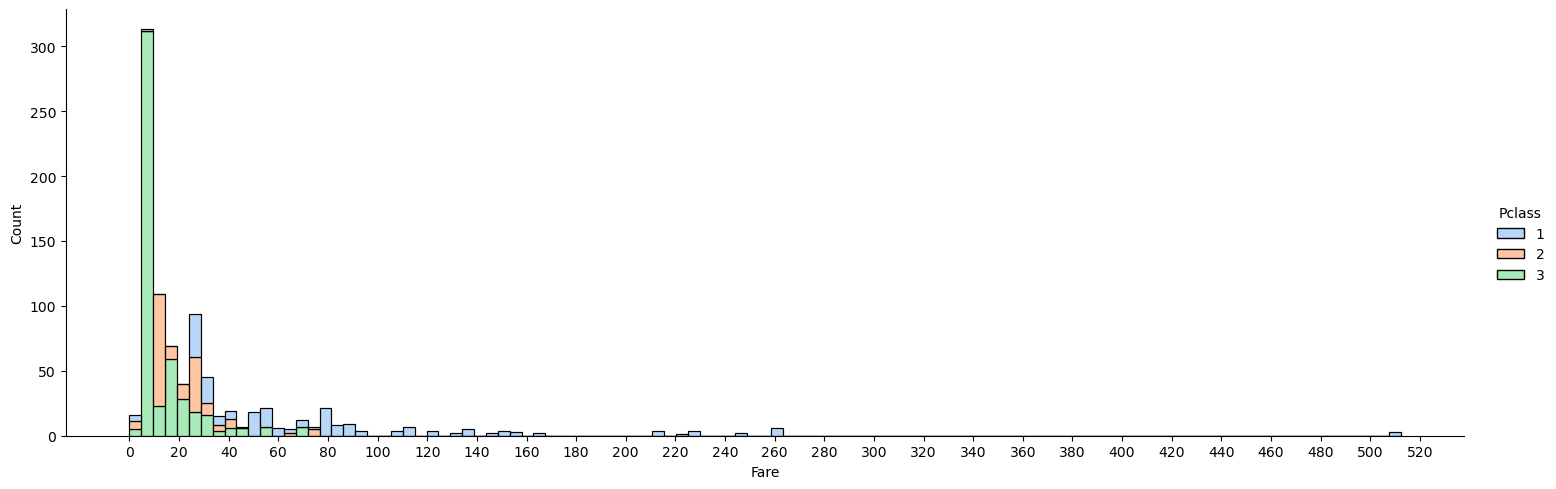

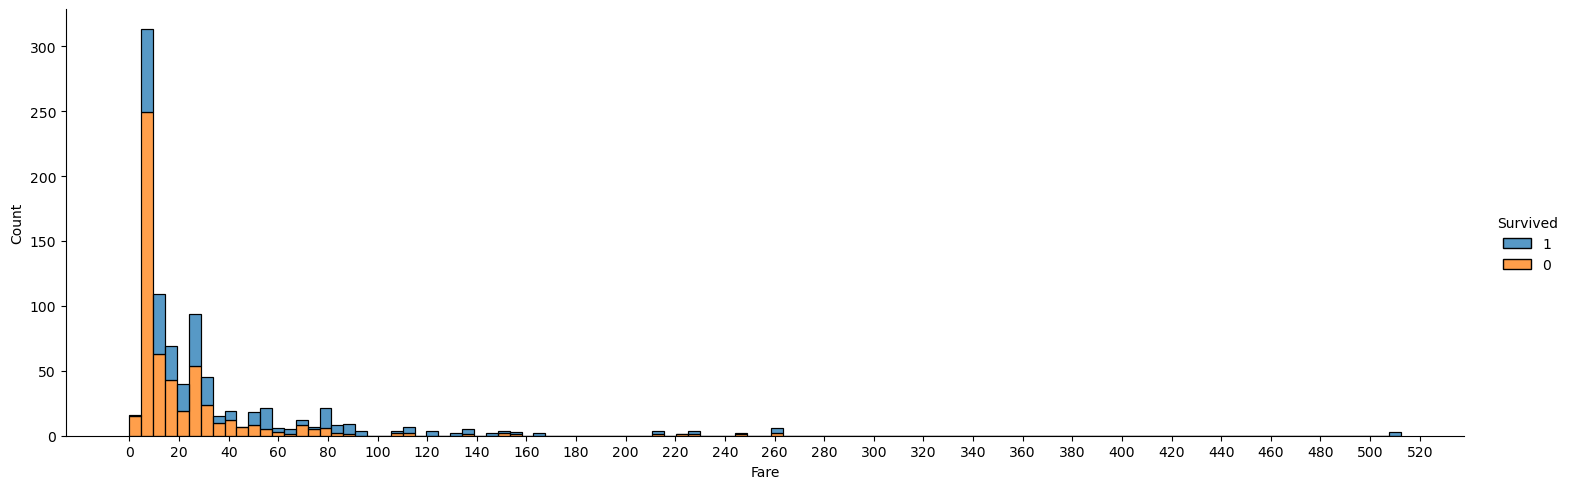

In [18]:
sns.displot(data=dfv01,  x='Fare', hue='Pclass',multiple="stack", aspect=3, 
            palette=sns.color_palette("pastel",3)).set_titles("all")
plt.xticks([x for x in range(0,540,20)])

sns.displot(data=dfv01,  x='Fare', hue='Survived',multiple="stack", aspect=3,hue_order= [1, 0],
            palette=sns.color_palette()).set_titles("survived")
plt.xticks([x for x in range(0,540,20)])
plt.show()

* Distribution of numeric data is non gaussian therefore nonparametric models will better suit this classification task.
* There are huge outliers in fare attribute
* Pclass don't have strict dependence on fare.

/tmp/ipykernel_21/1879372782.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True)


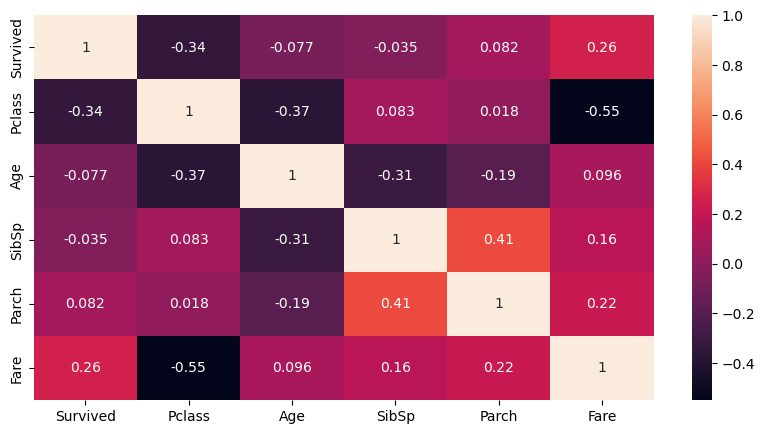

In [19]:
fig, ax = plt.subplots(figsize=(10,5)) 
dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True)
plt.show()

* Survived and Pclass have high negative correlation: class 1 and class 2 should have higher survival rate then class 3
* Fare is moderately correlated to survival
* While Pclass don't have strict dependence on fare, Fare and Pclass is highly correlated
* Pclass have high negative correlationcorrelation with age

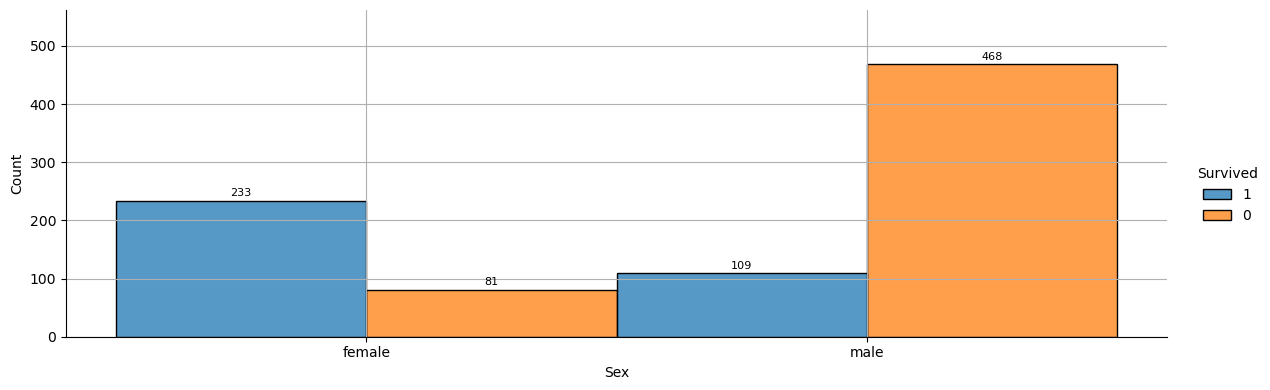

In [20]:
ax=sns.displot( dfv01 , x = 'Sex', hue='Survived' , hue_order= [1, 0],
               multiple="dodge",height=4, aspect=3)

plt.grid() 
show_values(ax)

Seems like women given priorty for rescue with more emphasis then Pclass

/tmp/ipykernel_21/1504848729.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data=dfv01,  x='Age', hue='Survived',hue_order= [1, 0], element="poly",


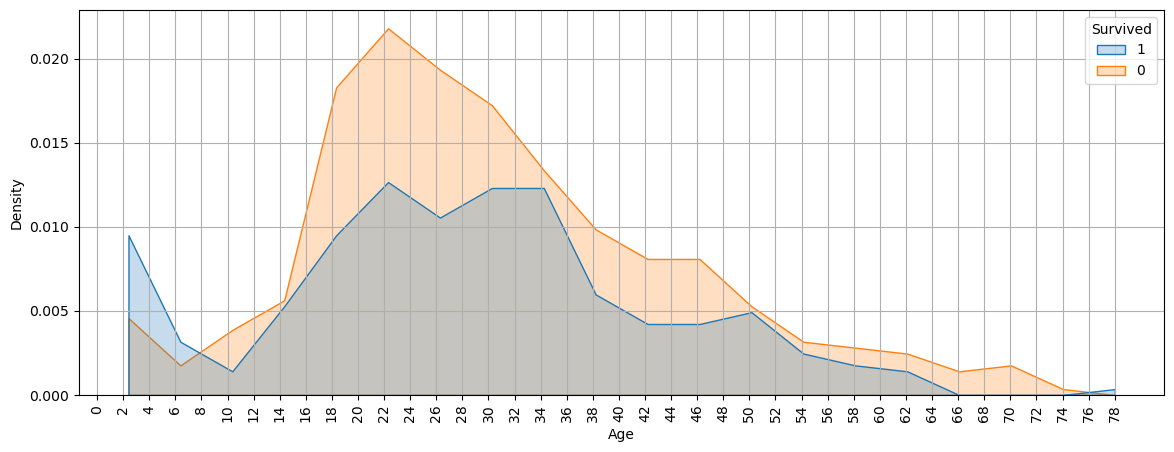

In [21]:
fig, ax = plt.subplots(figsize=(14,5)) 
sns.histplot(data=dfv01,  x='Age', hue='Survived',hue_order= [1, 0], element="poly",
    stat="density", palette=sns.color_palette())
ax.set(xticks=[x for x in range(int(dfv01['Age'].min()),int(dfv01['Age'].max()),2)])
plt.xticks(rotation=90)
plt.grid() 
plt.show()

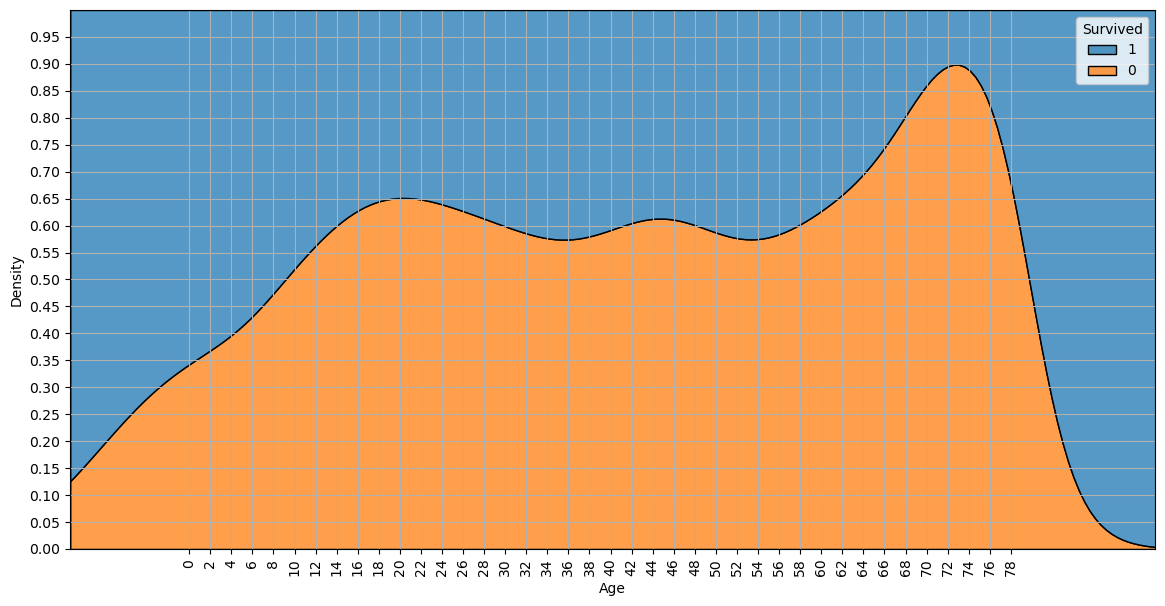

In [22]:
fig, ax = plt.subplots(figsize=(14,7)) 
sns.kdeplot(data=dfv01, x="Age", hue="Survived",hue_order= [1, 0], multiple="fill")
ax.set(xticks=[x for x in range(int(dfv01['Age'].min()),int(dfv01['Age'].max()),2)])
ax.set(yticks=[x/100 for x in range(0,100,5)])
plt.xticks(rotation=90)
plt.grid() 
plt.show()

# # 

/tmp/ipykernel_21/2125351630.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pclass_fare = dfv01.groupby(["Survived"]).mean()["Fare"]


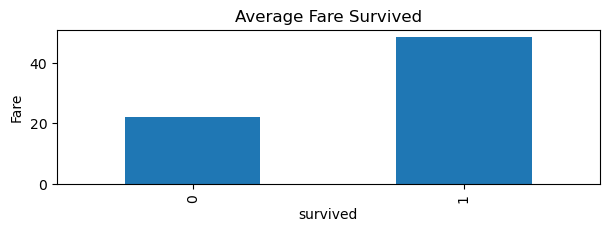

In [23]:
fig, ax = plt.subplots(figsize=(7, 2))
pclass_fare = dfv01.groupby(["Survived"]).mean()["Fare"]
pclass_fare.plot.bar(ax=ax)
_ = ax.set(
    title="Average Fare Survived",
    xlabel="survived",
    ylabel="Fare",
)

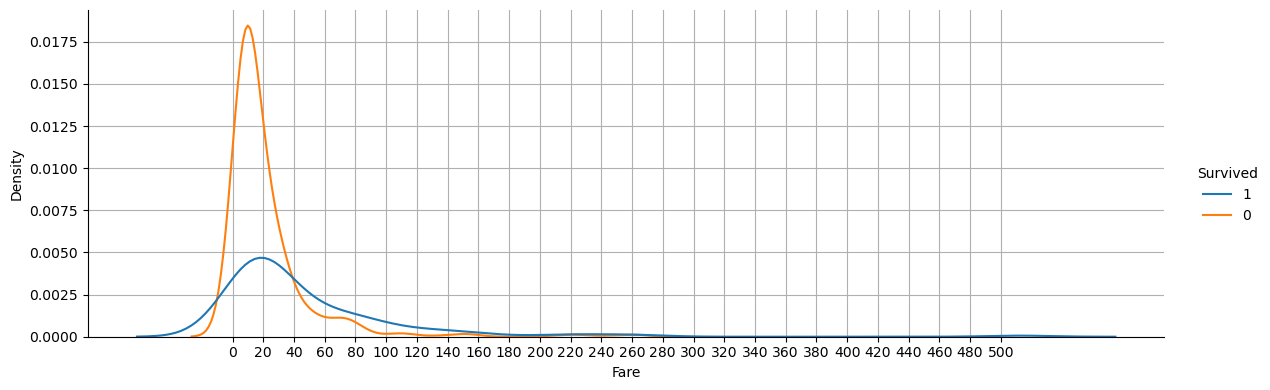

In [24]:
ax=sns.displot( dfv01 , x = 'Fare', hue='Survived' ,hue_order= [1, 0], kind = 'kde',height=4, aspect=3)
ax.set(xticks=[x for x in range(int(dfv01['Fare'].min()),int(dfv01['Fare'].max()),20)])
plt.grid() 
plt.show()

* People who paid more survived more so average fare of survivors double the average fare of ppl lost
* After Fare= 40 survival rate is higher then rate of death

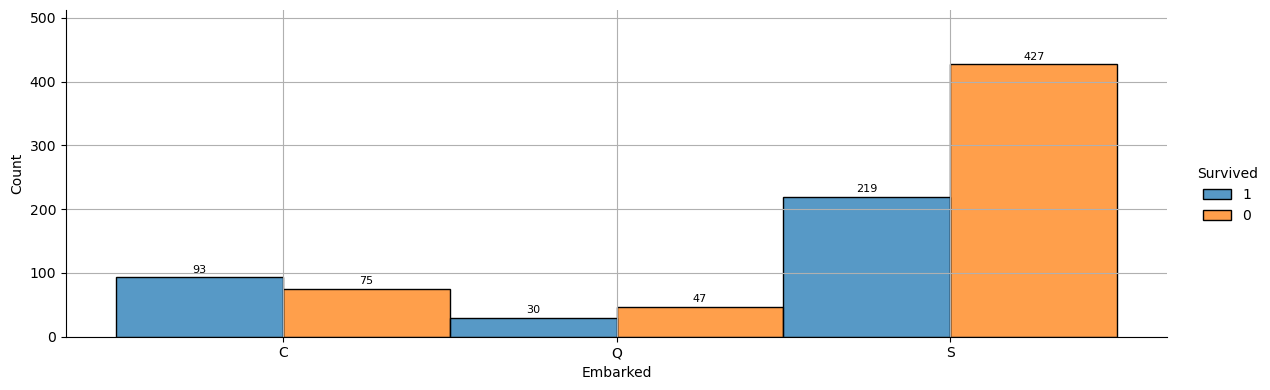

In [25]:
ax=sns.displot( dfv01 , x = 'Embarked', hue='Survived' , multiple="dodge",hue_order= [1, 0],height=4, aspect=3)

plt.grid() 
show_values(ax)

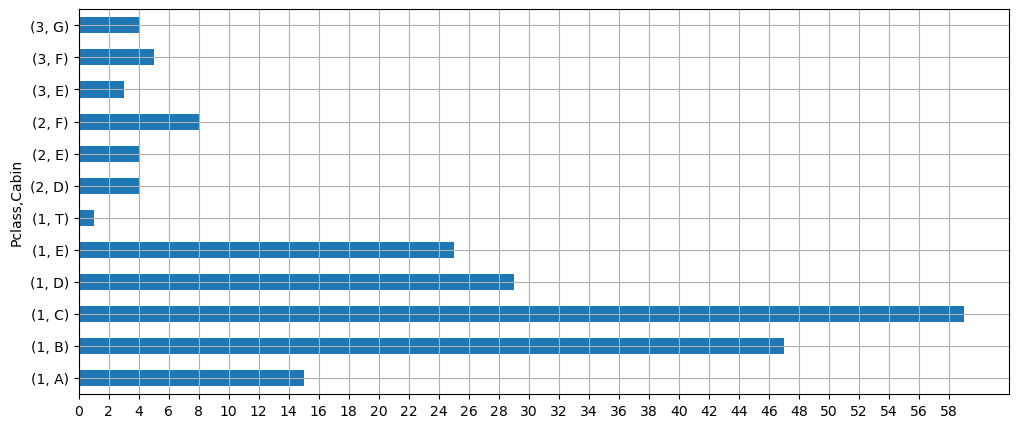

In [26]:
Deck=dfv01['Cabin'].str[0]
fig, ax = plt.subplots(figsize=(12, 5))
dfv01.groupby(['Pclass',Deck]).count()["PassengerId"].plot.barh()
plt.xticks([x for x in range(0,60,2)])
plt.grid() 

* Fix problem with empty values/outliers in cabin, extract first letter to represent deck and mark unknown to encode as accordingly.
* Derive title from name then categorize in to more general segments
* Derive a new feature "alt_sex" which have female, male, female_kid, male_kid, adult male with kid and adult female with kid classes.
* Derive feature "group size" and "Max group size"
* Derive fare per person fix skewness.
* Impute fare & age
* Derive total number of adult male, adult female and children in group and add them as feature.
* categorise age
* bin fare